In [1]:
import numpy as np
import pandas as pd

# Load the data

## NY Times

In [3]:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
df = pd.read_csv(url, parse_dates=[0])  # Cols: date, state, fips, cases, deaths 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11069 entries, 0 to 11068
Data columns (total 5 columns):
date      11069 non-null datetime64[ns]
state     11069 non-null object
fips      11069 non-null int64
cases     11069 non-null int64
deaths    11069 non-null int64
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 432.5+ KB


The **fips** code can be used for getting the location info for the plots. Rest are self-understandable.

## Wikipedia population data

In [4]:
url = 'https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States_by_population'
pop_df = pd.read_html(url)[0]

In [5]:
pop_df.head()

Rank              State         Census population                   \
  Current 2010         State Estimate, July 1, 2019[8] April 1, 2010[9]   
0     1.0  1.0    California                  39512223         37253956   
1     2.0  2.0         Texas                  28995881         25145561   
2     3.0  4.0       Florida                  21477737         18801310   
3     4.0  3.0      New York                  19453561         19378102   
4     5.0  6.0  Pennsylvania                  12801989         12702379   

  Change, 2010–2019             Total U.S. House of Representatives Seats  \
    Percent[note 3]    Absolute Total U.S. House of Representatives Seats   
0              6.1%  +2,257,700                                        53   
1             15.3%  +3,850,320                                        36   
2             14.2%  +2,676,427                                        27   
3              0.4%     +75,459                                        27   
4              0.8%     +99,610                                        18   

  Estimated population per electoral vote, 2019[note 1]  \
  Estimated population per electoral vote, 2019[note 1]   
0                                             718404      
1                                             763050      
2                                             740611      
3                                             670812      
4                                             640099      

  Census population per House seat          \
                   Estimated, 2019    2010   
0                           745514  702885   
1                           805441  698503   
2                           795472  696468   
3                           720502  717707   
4                           711222  705715   

  Percent of the total U.S. population, 2019[note 2]  
  Percent of the total U.S. population, 2019[note 2]  
0                                             11.91%  
1                                              8.74%  
2                                              6.47%  
3                                              5.86%  
4                                              3.86%

In [6]:
pop_df = pop_df.iloc[:,2:4]
pop_df = pop_df.droplevel(0, axis=1)
pop_df.tail(10)

,State,"Estimate, July 1, 2019[8]"
50,Vermont,623989
51,Wyoming,578759
52,Guam,"168,485[10]"
53,U.S. Virgin Islands,"106,235[12]"
54,Northern Mariana Islands,"51,433[14]"
55,American Samoa,"49,437[16]"
56,Contiguous United States,325386357
57,The fifty states,327533795
58,Fifty states + D.C.,328239523
59,Total U.S. (including D.C. and territories),331808807


### Pre-processing population data

In [7]:
# Checking states names that are same before merging

s_df = set(df.state.unique())
s_pop = set(pop_df.State)

intersect = s_df.intersection(s_pop)
intersect = list(intersect)
print(f'For {len(intersect)} states, the names are common.')

print(f'\nState names in population data not common are:')
for state in s_pop.difference(intersect):
    print(state)
print(f'\nState names in COVID-19 data not common are:')
for state in s_df.difference(intersect):
    print(state)

For 54 states, the names are common.

State names in population data not common are:
American Samoa
Fifty states + D.C.
U.S. Virgin Islands
Contiguous United States
Total U.S. (including D.C. and territories)
The fifty states

State names in COVID-19 data not common are:
Virgin Islands


It's best to remove the least populous territories as they're bound to underfit and the total counts as they won't be merged eventually. With data being sorted in the correct order, the data from `pop_df` before 52nd entry is enough. Thus, keeping only data till Wyoming for this study.

In [8]:
pop_df = pop_df[:52]
pop_df.tail()

,State,"Estimate, July 1, 2019[8]"
47,North Dakota,762062
48,Alaska,731545
49,District of Columbia,705749
50,Vermont,623989
51,Wyoming,578759


In [9]:
import re
import warnings
warnings.filterwarnings("ignore")

def pre_process(total_pop):
    '''Pre-process population values where in some cases the references might 
    have '...[..]' pattern signifying reference
    '''
    try:
        num = int(total_pop)
    except:
        m = re.match(r'\d+[\d+]', total_pop)
        num = int(m.group(0))

    return num

pop_df.rename(columns={pop_df.columns[1]: 'Recent_population'}, inplace=True)

pop_df['Recent_population'] = pop_df['Recent_population'].apply(pre_process)

pop_df.sort_values(by='Recent_population')
pop_df.head()

,State,Recent_population
0,California,39512223
1,Texas,28995881
2,Florida,21477737
3,New York,19453561
4,Pennsylvania,12801989


## Merging and computing

In [10]:
data = pd.merge(pop_df, df, left_on='State', right_on='state')

In [13]:
data['cases_per_capita'] = data.cases / data.Recent_population
data['deaths_per_capita'] = data.deaths / data.Recent_population

data.drop(columns=['State', 'Recent_population'], inplace=True).set_index('date')

# data = data.set_index('date').drop(columns='Recent_population') 
data.head()

,Recent_population,date,state,fips,cases,deaths,cases_per_capita,deaths_per_capita
0,39512223,2020-01-25,California,6,1,0,2.530862e-08,0.0
1,39512223,2020-01-26,California,6,2,0,5.061725e-08,0.0
2,39512223,2020-01-27,California,6,2,0,5.061725e-08,0.0
3,39512223,2020-01-28,California,6,2,0,5.061725e-08,0.0
4,39512223,2020-01-29,California,6,2,0,5.061725e-08,0.0


In [15]:
len(data.state.unique())

52

# Analysis

 ## State-wise Analysis
 
 Let's analyze the growth pattern across various states

In [23]:
temp.head()

,date,state,fips,cases,deaths,Recent_population,cases_per_capita,deaths_per_capita
0,2020-01-21,Washington,53,1,0,7614893,1.313216e-07,0.0
1,2020-01-22,Washington,53,1,0,7614893,1.313216e-07,0.0
2,2020-01-23,Washington,53,1,0,7614893,1.313216e-07,0.0
3,2020-01-24,Washington,53,1,0,7614893,1.313216e-07,0.0
4,2020-01-25,Washington,53,1,0,7614893,1.313216e-07,0.0


In [30]:
temp = data[data.state == 'Washington']
temp.set_index('date', inplace=True)

In [31]:
cases_df = temp['cases']
cases_df.head()

date
2020-01-21    1
2020-01-22    1
2020-01-23    1
2020-01-24    1
2020-01-25    1
Name: cases, dtype: int64

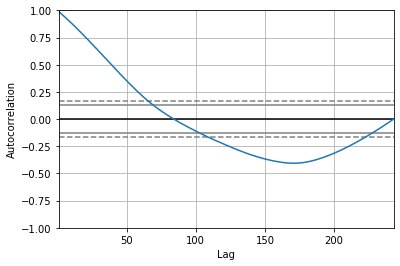

In [33]:
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt

autocorrelation_plot(cases_df)
plt.show()

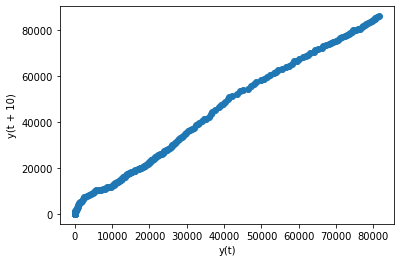

In [55]:
from pandas.plotting import lag_plot

lag_plot(cases_df, lag=10)

In [73]:
lag_plot??

,date,state,fips,cases,deaths,Recent_population,cases_per_capita,deaths_per_capita
11068,2020-09-19,Northern Mariana Islands,69,68,2,51,1.333333e+00,0.039216
10955,2020-05-29,Northern Mariana Islands,69,22,2,51,4.313725e-01,0.039216
10954,2020-05-28,Northern Mariana Islands,69,22,2,51,4.313725e-01,0.039216
10953,2020-05-27,Northern Mariana Islands,69,22,2,51,4.313725e-01,0.039216
10952,2020-05-26,Northern Mariana Islands,69,22,2,51,4.313725e-01,0.039216
...,...,...,...,...,...,...,...,...
632,2020-06-22,California,6,184620,5561,39512223,4.672478e-03,0.000141
631,2020-06-21,California,6,178807,5517,39512223,4.525359e-03,0.000140
630,2020-06-20,California,6,174854,5495,39512223,4.425314e-03,0.000139
628,2020-06-18,California,6,167135,5359,39512223,4.229957e-03,0.000136


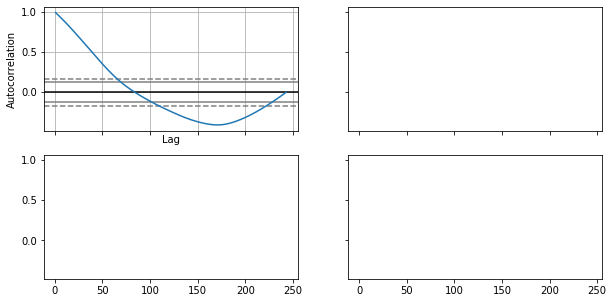

In [72]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,5))

autocorrelation_plot(cases_df, ax=axes[0,0])
# lag_plot(cases_df, lag=1, ax=axes[0,1])


In [37]:
def visualize_autocorrelation(df, col):
    
    states = df.state.unique()
    df=df.set_index('date')
    
    for s in states:
        state_df = df[df.state == s]
        
        autocorrelation_plot(state_df[col])
        plt.title(s)
        plt.show()

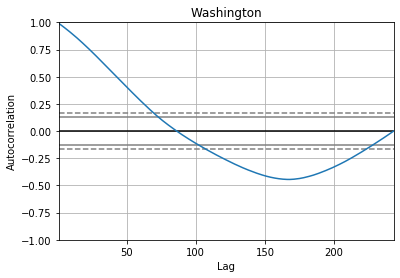

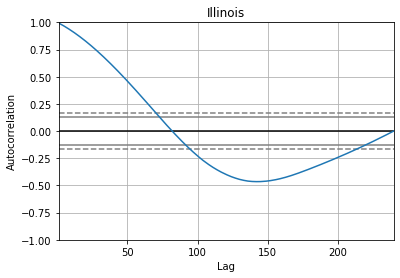

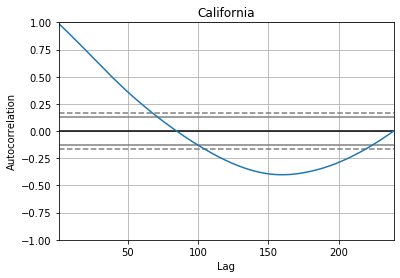

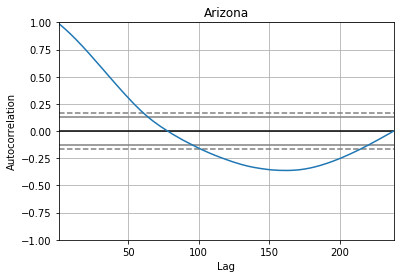

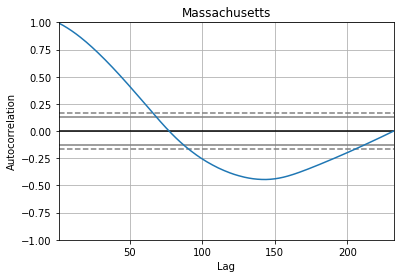

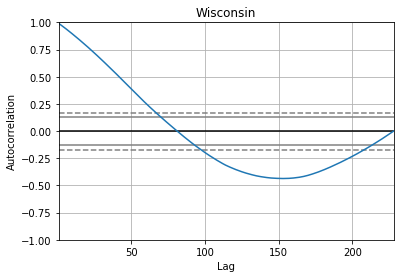

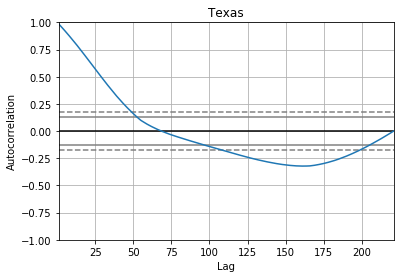

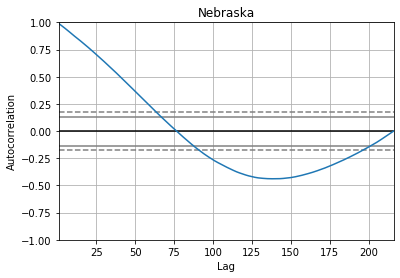

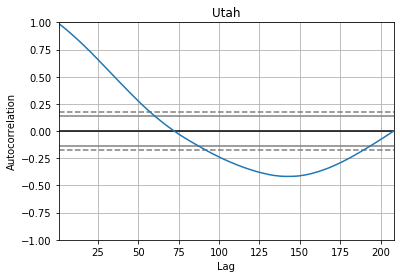

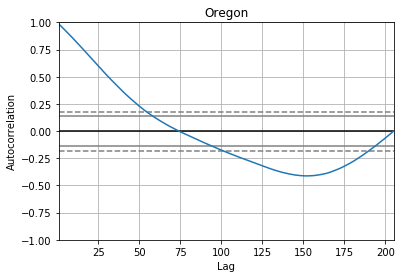

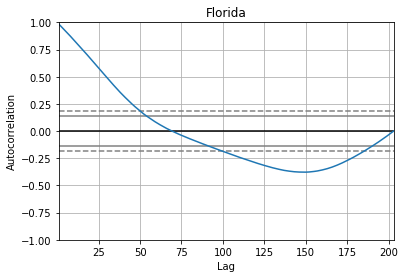

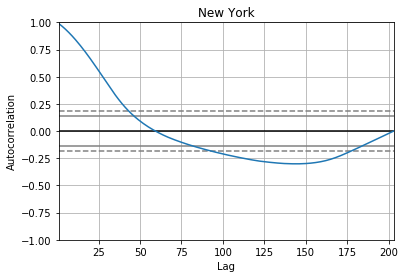

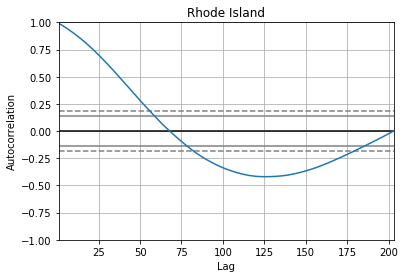

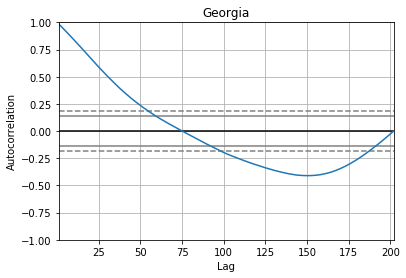

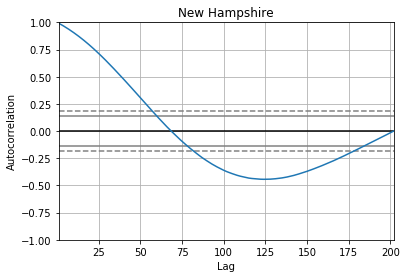

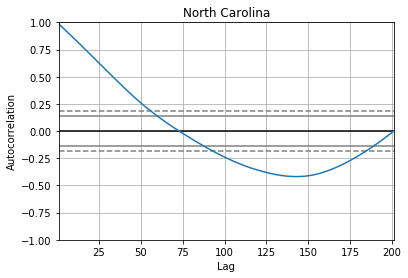

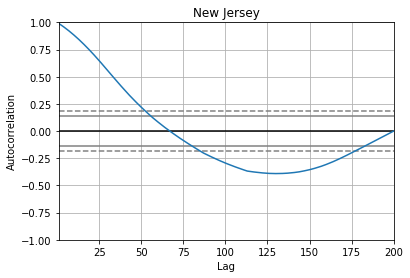

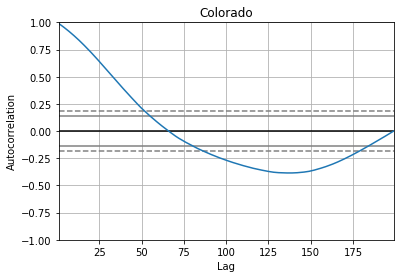

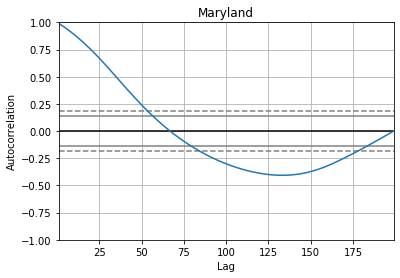

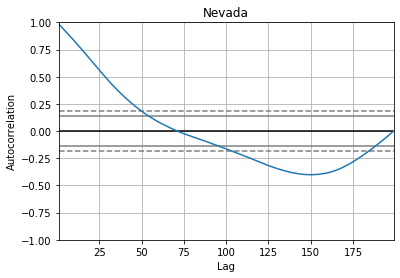

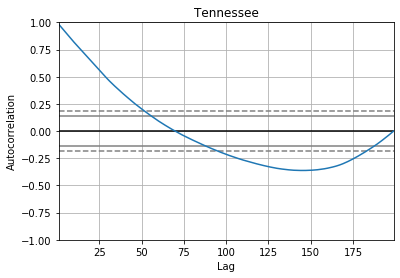

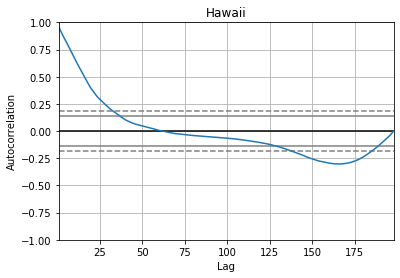

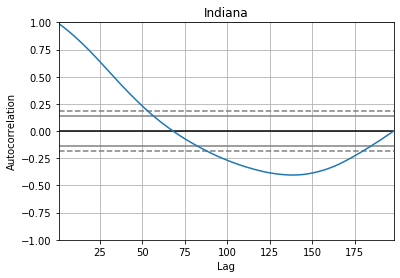

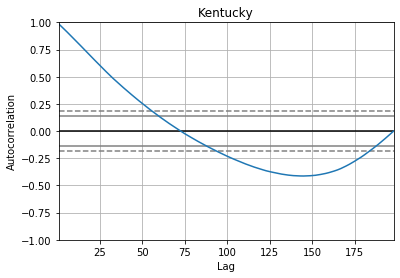

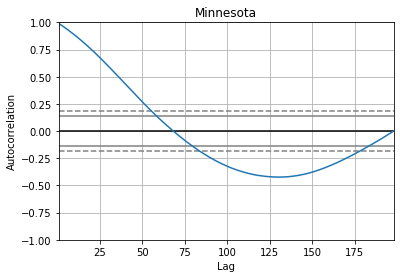

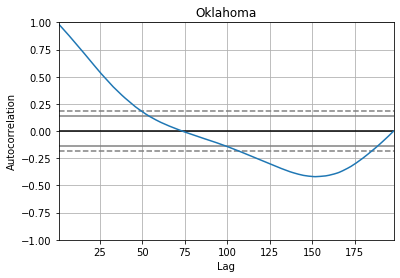

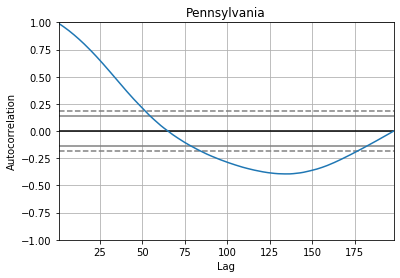

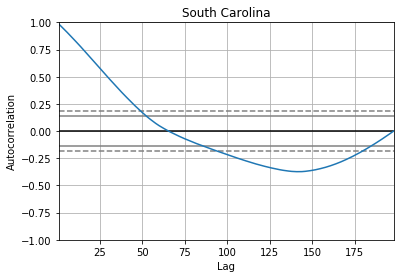

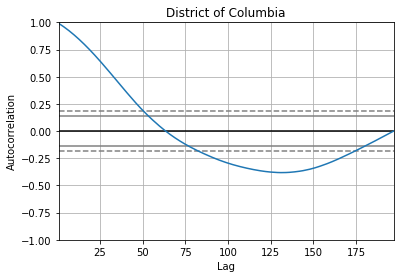

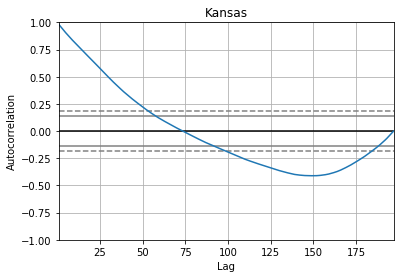

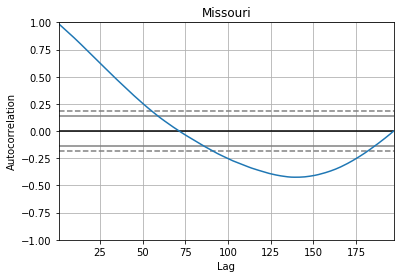

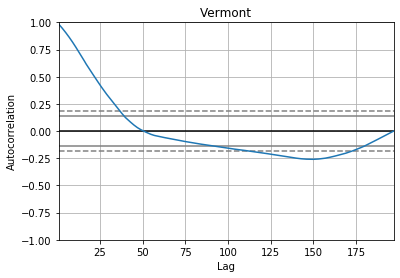

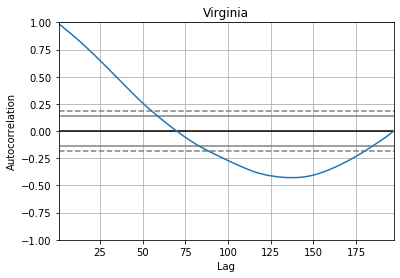

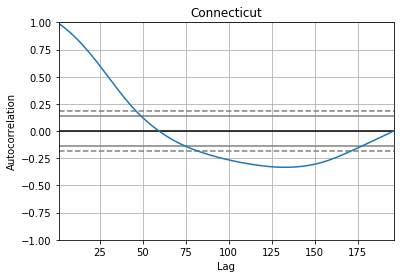

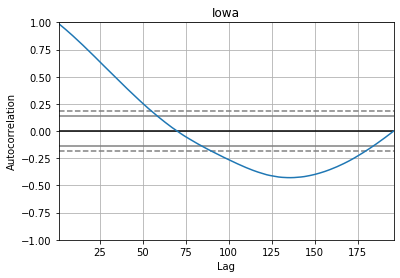

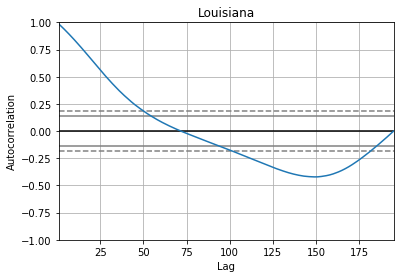

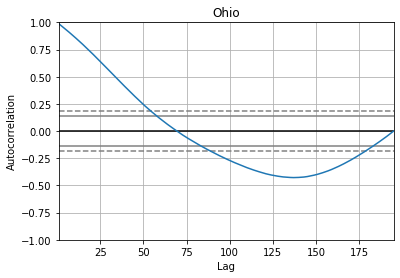

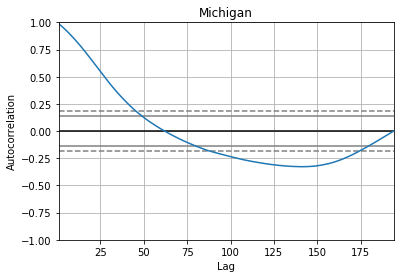

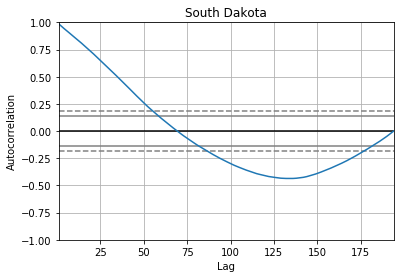

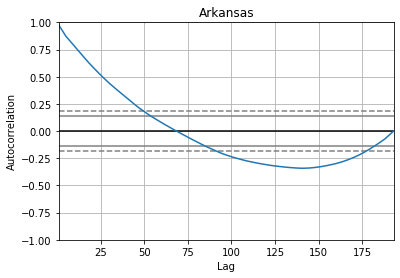

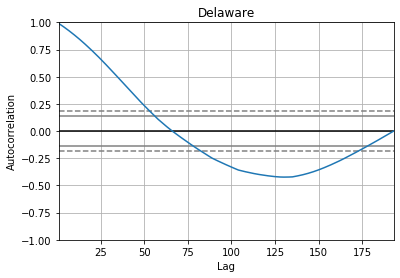

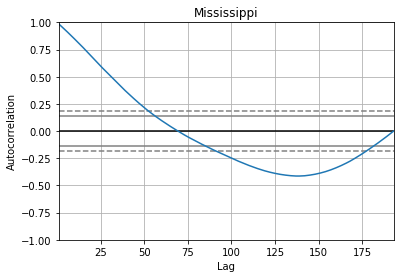

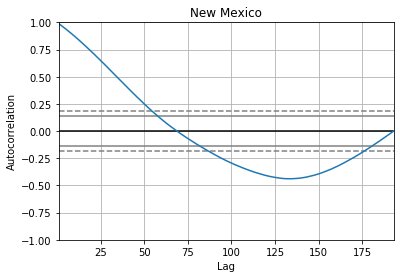

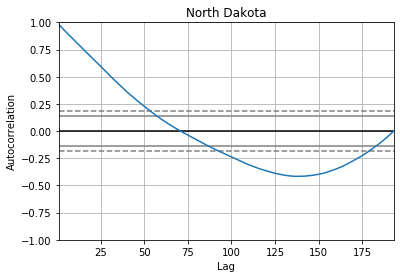

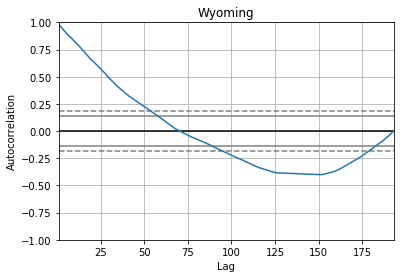

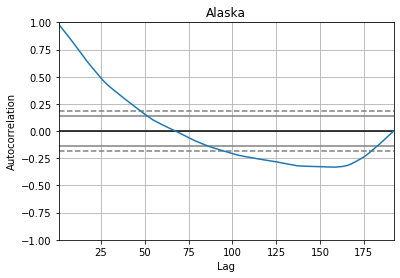

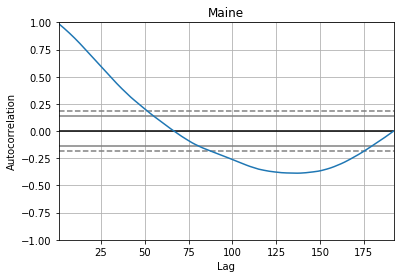

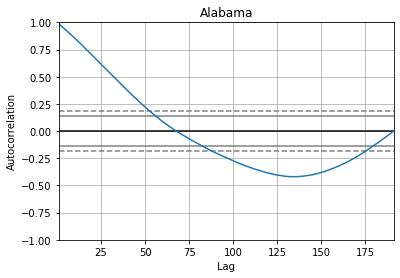

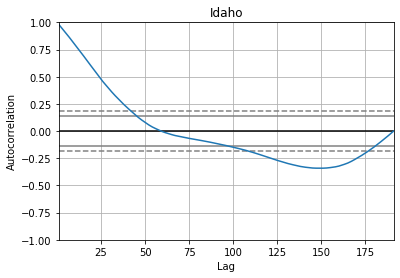

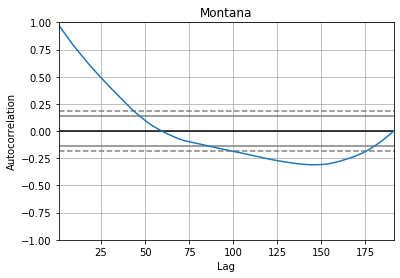

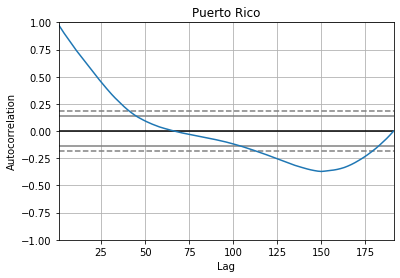

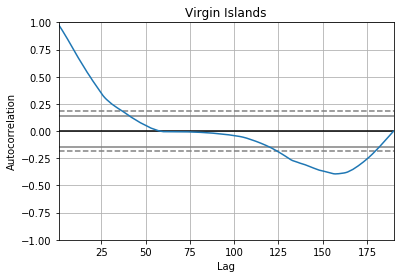

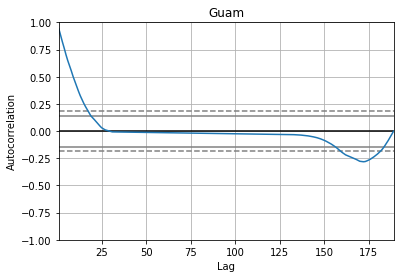

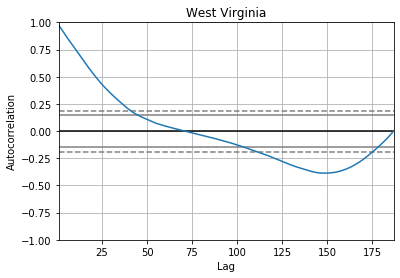

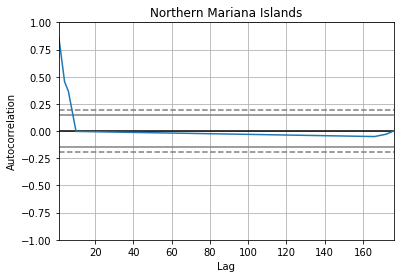

In [49]:
visualize_autocorrelation(df, 'deaths')

# Model

In [ ]:
from statsmodels.tsa.arima.model import ARIMA


# Other

In [16]:
state_df = df.groupby('state')

In [21]:
state_df.count()

,date,fips,cases,deaths
state,,,,
Alabama,187,187,187,187
Alaska,188,188,188,188
Arizona,234,234,234,234
Arkansas,189,189,189,189
California,235,235,235,235
Colorado,195,195,195,195
Connecticut,192,192,192,192
Delaware,189,189,189,189
District of Columbia,193,193,193,193


In [17]:
state_df.plot.bar()

C:\Users\ksmai\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


state
Alabama                     AxesSubplot(0.125,0.11;0.775x0.77)
Alaska                      AxesSubplot(0.125,0.11;0.775x0.77)
Arizona                     AxesSubplot(0.125,0.11;0.775x0.77)
Arkansas                    AxesSubplot(0.125,0.11;0.775x0.77)
California                  AxesSubplot(0.125,0.11;0.775x0.77)
Colorado                    AxesSubplot(0.125,0.11;0.775x0.77)
Connecticut                 AxesSubplot(0.125,0.11;0.775x0.77)
Delaware                    AxesSubplot(0.125,0.11;0.775x0.77)
District of Columbia        AxesSubplot(0.125,0.11;0.775x0.77)
Florida                     AxesSubplot(0.125,0.11;0.775x0.77)
Georgia                     AxesSubplot(0.125,0.11;0.775x0.77)
Guam                        AxesSubplot(0.125,0.11;0.775x0.77)
Hawaii                      AxesSubplot(0.125,0.11;0.775x0.77)
Idaho                       AxesSubplot(0.125,0.11;0.775x0.77)
Illinois                    AxesSubplot(0.125,0.11;0.775x0.77)
Indiana                     AxesSubplot(0.125,0.1

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000002CD7B1B61F8> (for post_execute):


ValueError: view limit minimum 0.0 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

state
Alabama                     AxesSubplot(0.125,0.125;0.775x0.755)
Alaska                      AxesSubplot(0.125,0.125;0.775x0.755)
Arizona                     AxesSubplot(0.125,0.125;0.775x0.755)
Arkansas                    AxesSubplot(0.125,0.125;0.775x0.755)
California                  AxesSubplot(0.125,0.125;0.775x0.755)
Colorado                    AxesSubplot(0.125,0.125;0.775x0.755)
Connecticut                 AxesSubplot(0.125,0.125;0.775x0.755)
Delaware                    AxesSubplot(0.125,0.125;0.775x0.755)
District of Columbia        AxesSubplot(0.125,0.125;0.775x0.755)
Florida                     AxesSubplot(0.125,0.125;0.775x0.755)
Georgia                     AxesSubplot(0.125,0.125;0.775x0.755)
Guam                        AxesSubplot(0.125,0.125;0.775x0.755)
Hawaii                      AxesSubplot(0.125,0.125;0.775x0.755)
Idaho                       AxesSubplot(0.125,0.125;0.775x0.755)
Illinois                    AxesSubplot(0.125,0.125;0.775x0.755)
Indiana            

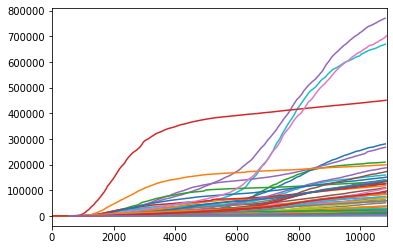

In [23]:
state_df['cases'].plot()